In [27]:
import os, sys
sys.path.insert(0, '/home/jtorrenc/mvesc/ETL')
from mvesc_utility_functions import *
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [127]:
def build_outcomes_plus_features(subset_n=None):
    with postgres_pgconnection_generator() as connection:
        #outcome_name = model_options['outcome_name']
        outcome_name = 'definite'
        outcomes_with_student_lookup = read_table_to_df(connection,
            table_name = 'outcome', schema = 'model', nrows = -1,
            columns = ['student_lookup', outcome_name, 'cohort_9th'])
        outcomes_with_student_lookup.dropna(inplace=True)
        if subset_n:
            fraction = subset_n/float(outcomes_with_student_lookup.shape[0])
            print(fraction)
            outcomes_with_student_lookup = outcomes_with_student_lookup \
            .groupby(outcome_name).apply(lambda x :x.sample(frac=fraction))
            outcomes_with_student_lookup.index = outcomes_with_student_lookup.index.droplevel()
    return outcomes_with_student_lookup

In [136]:
a = build_outcomes_plus_features(100)
outcome_name = 'definite'

0.01073998496402105


In [137]:
a.groupby(outcome_name).agg('count')

,student_lookup,cohort_9th
definite,,
0.0,96,96
1.0,4,4


In [138]:
a[outcome_name].eq(1).any()

True

In [139]:
print(a.head(1))
a.set_value(a.index[0],outcome_name,1)
print(a.head(1))

      student_lookup  definite  cohort_9th
9490          9736.0       0.0        2012
      student_lookup  definite  cohort_9th
9490          9736.0       1.0        2012


In [110]:
a

,student_lookup,definite,cohort_9th
6630,40863.0,0.0,2011
2852,36764.0,0.0,2008
9840,7887.0,0.0,2012
7215,42820.0,0.0,2011
8949,13182.0,0.0,2012
10543,16715.0,0.0,2012
2689,41203.0,0.0,2008
4335,40724.0,0.0,2009
5350,42072.0,0.0,2010
3718,34908.0,0.0,2009


In [42]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

In [43]:
def plot_precision_recall_n(y_true, y_prob):
    """                                                                          
    Adapted from Rayid's magicloops code, this plots precision and recall        
    vs. the percent of population marked as 1                                    
                                                                                 
    :param pd.Series y_true:                                                     
    :param pd.Series y_prob:                                                     
    :param str save_location:                                                    
    :param str run_name:                                                         
    :param str model_name:                                                       
    """
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true\
, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylim([0,1])
    ax1.set_xlim([0,1])
    ax1.set_ylabel('precision', color='b')

    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim([0,1])
    ax2.set_xlim([0,1])
    plt.show()

In [134]:
def plot_precision_recall_k(y_true, y_scores):
    """                                                                          
    Adapted from Rayid's magicloops code, this plots precision and recall        
    vs. the percent of population marked as 1                                    
                                                                                 
    :param pd.Series y_true:                                                     
    :param pd.Series y_prob:                                                     
    :param str save_location:                                                    
    :param str run_name:                                                         
    :param str model_name:                                                       
    """
    n = len(y_scores)
    precision_curve = np.zeros([n,1])
    recall_curve = np.zeros([n,1])
    ranks = y_scores.rank(method='first', ascending=False)
    for i in range(n):
        pred = pd.Series([1 if r <= i+1 else 0 for r in ranks])
        precision_curve[i] = precision_score(y_true, pred)
        recall_curve[i] = recall_score(y_true, pred)
    plt.clf()
    fig, ax1 = plt.subplots()
    percents = (np.arange(n)+1)/n
    ax1.plot(percents, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylim([0,1])
    ax1.set_xlim([0,1])
    ax1.set_ylabel('precision', color='b')

    ax2 = ax1.twinx()
    ax2.plot(percents, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim([0,1])
    ax2.set_xlim([0,1])
    plt.show()

In [171]:
# y_true = pd.Series(np.ones(100))
# y_true[:70] = 0
# y_prob = pd.Series(np.arange(100)*.1)
# pd.DataFrame({'true':y_true, 'predicted':y_prob})


y_true = pd.Series(np.random.binomial(1,.5,100))
y_prob = pd.Series(np.ones(100)*.5)
y_prob[:20] = (np.arange(20,0,-1)+20)/40
y_prob[-20:] = (np.arange(20,0,-1))/40
pd.DataFrame({'true':y_true, 'predicted':y_prob})

# y_true = pd.Series(np.ones(100))
# y_true[:70] = 0
# y_prob = pd.Series(np.arange(100)*.1 + np.random.random(100)*10) 
# #pd.DataFrame({'true':y_true, 'predicted':y_prob})

,predicted,true
0,1.000,1
1,0.975,1
2,0.950,0
3,0.925,0
4,0.900,1
5,0.875,0
6,0.850,1
7,0.825,0
8,0.800,1
9,0.775,0


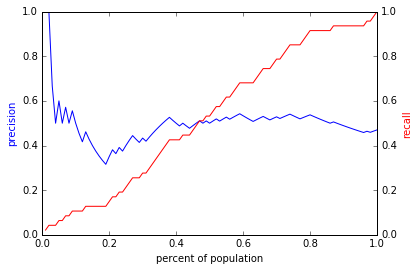

In [172]:
plot_precision_recall_k(y_true, y_prob)

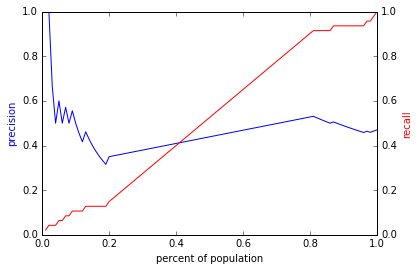

In [173]:
plot_precision_recall_n(y_true, y_prob)